Attention Layer with Contrastive Learning

In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from data.utils import SimpleDataset

from utils.metrics import NLL_reg, point_loss, get_CI_raw
from utils.trainer_helpers import batch_t_categorize, wt_avg



## Cox-gompertz linear setting

Load framingham dataset

In [3]:
from data.simulation import simulation_cox_weibull_all, single_subj_true_dist_cox_gompertz

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy_bin/e40'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=68)

# change to non-ohe 
cat0_level = df['ohe'][0]
cat1_level = df['ohe'][1]

# cat0 = 0*df['x'][:,2] + 1*df['x'][:,3]+ 2*df['x'][:,4]+ 3*df['x'][:,5]
cat0 = np.sum(np.array([level*df['x'][:, 2+level] for level in range(cat0_level)]),0).reshape(-1,1)
cat1 = np.sum(np.array([level*df['x'][:, 2+cat0_level+level] for level in range(cat1_level)]),0).reshape(-1,1)


df['x'] = np.concatenate((df['x'][:,df['cts_idx']], cat0, cat1), axis=1)
nsamples, ncov= df['x'].shape

cov_list = np.array(['AGE','RANDON', 'cat0','cat1'])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]


true_beta = df['coef']
ncov, np.mean(df['e'])

(4, 0.41815)

In [4]:
cts_idx

array([0, 1])

In [5]:
# sns.countplot(df['x'][:,-1]), cat_idx

<AxesSubplot:ylabel='Density'>

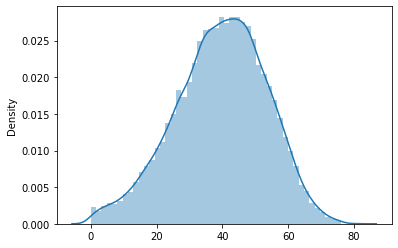

In [6]:
sns.distplot(df['T'])

In [7]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

del df

observed fold:0.4176854421360534
observed fold:0.41907904604769763


In [8]:
nbin=10
# tt = np.percentile(train['t'][train['e']==1],np.linspace(0.,100.,nbin, endpoint=True))
tt = np.linspace(0.,np.max(train['t'][train['e']==1]),nbin, endpoint=True)

# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    nbin = nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)
t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
tt, t_all_max, t_max

(array([ 0.        ,  7.50932559, 15.01865118, 22.52797677, 30.03730236,
        37.54662795, 45.05595354, 52.56527913, 60.07460473, 67.58393032,
        68.        ]),
 68.0,
 67.58393031622197)

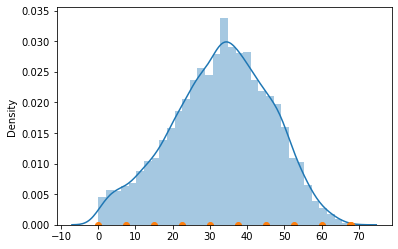

In [9]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [10]:
def landmarks_init(dataset, m, cts_var=None, cts_idx = None, device='cpu'):
    '''
    continuous_idx: 
    
    '''
    if type(cts_var) == type(None):
        cts_idx = np.arange(dataset['x'].shape[1])
        cts_var = cts_idx
    
    # creat landmarks as traditional dictionary
    x_landmarks = {}

    [x_landmarks.update({var: torch.tensor(np.percentile(dataset['x'][:,c_idx], np.linspace(0,100,m))).to(device).contiguous()}) for c_idx, var in zip(cts_idx, cts_var)]

    # save the initialized landmarks as a torch parameter dictionary
    x_emb_landmarks = nn.ParameterDict({})
    for var in cts_var:
        m = len(x_landmarks[var])
        x_emb_landmark = torch.eye(m)
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_landmark)})
        x_emb_landmarks.update(new_dict)
        
    return x_landmarks, x_emb_landmarks

# x_landmarks, x_emb_landmarks = landmarks_init(train, m, continuous_variables)
# x_landmarks, x_emb_landmarks

In [11]:
# x_landmarks, x_emb_landmarks = landmarks_init(train, 10, cts_var, cts_idx, device='cuda')
# x_landmarks, x_emb_landmarks

In [12]:
# x_landmarks.keys(), x_emb_landmarks.keys()

### Linear Interpolation for continuous variables

$x_b \le x < x_{b+1}$, $\text{emb}(x) = \text{emb}(x_b) + \frac{\text{emb}(x_{b+1}) - \text{emb}(x_b)}{x_{b+1}-x_b}(x-x_{b})$

In [13]:

# def linear_interpolation_np(x, x_landmarks):
#     # apply numpy package
#     m = len(x_landmarks)
#     x_emb_landmarks = np.eye(m)
#     # returns index
#     # a[i-1] < v <= a[i]
#     indx = np.searchsorted(x_landmarks, x)
#     # combine the first two indices, and the last two indices
#     # to include the unobserved minimum and maximum value
#     # combines [0,1], and [m-1, m]
#     indx = np.where(indx==0, 1, indx)
#     indx = np.where(indx==m, m-1, indx)

#     # linear interpolation
#     def helper(idx, x0):
#         return x_emb_landmarks[idx-1] + (x0-x_landmarks[idx-1])*(x_emb_landmarks[idx] - x_emb_landmarks[idx-1])/(x_landmarks[idx]-x_landmarks[idx-1])
    
#     out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(np.vstack(out))


def linear_interpolation_var(x, x_landmark, x_emb_landmark):
    # written for torch
    # returns index
    # a[i-1] < v <= a[i]
    indx = torch.searchsorted(x_landmark, x)
    # combine the first two indices, and the last two indices
    # to include the unobserved minimum and maximum value
    # combines [0,1], and [m-1, m]
    indx = torch.where(indx==0, 1, indx)
    indx = torch.where(indx==m, m-1, indx)

    # linear interpolation
    def helper(idx, x0):
        return x_emb_landmark[idx-1] + (x0-x_landmark[idx-1])*(x_emb_landmark[idx] - x_emb_landmark[idx-1])/(x_landmark[idx]-x_landmark[idx-1])
    
    out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(torch.vstack(out))
    return torch.vstack(out)

In [14]:
def cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var=None, cts_idx=None):
    
#     m = len(x_landmarks[0])
    if type(cts_var) == type(None):
        cts_var = x_landmarks.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cts_idx, cts_var):
        m = len(x_landmarks[var])
        cur_emb = linear_interpolation_var(x[:,c_idx], x_landmarks[var], x_emb_landmarks[var])
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
#     return torch.cat(res, 1)

### Embedding categorical variables

Embed each level ($l$) of categorical variable, i.e., mapping each digit label to a length-m embedding vector, the $l$-th row of the embedding matrix.

In [15]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

def level_init(dataset, m, cat_var=None, cat_idx=None):
#     if type(categorical_variables)==type(None):
#         categorical_variables = np.arange(len(x_levels))
    x_levels = {} 
    [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
    # save the initialized landmarks as a dictionary
    x_emb_levels = nn.ParameterDict({})
    for var in cat_var:
        level = x_levels[var]
        # randomly pick one position as 1
        idx = np.random.choice(m)
        x_emb_level = torch.zeros(level, m)
#         x_emb_level = F.softmax(torch.rand(level, m),dim=-1)

        for l in range(level):
            idx = np.random.choice(m)
            x_emb_level[l, idx] = 1.0
    
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_level)})
        x_emb_levels.update(new_dict)
    return x_levels, x_emb_levels

In [16]:
def cat_interpolation(x, x_emb_levels, cat_var=None, cat_idx = None):
    if type(cat_var) == type(None):
        cat_var = x_emb_levels.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cat_idx, cat_var):
        cur_emb = x_emb_levels[var][x[:,c_idx].long()]
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
    

Linear interpolation batch by batch

In [17]:
# m = 10
# device='cpu'
# # Initiate landmarks with trainable paramters
# x_landmarks, x_emb_landmarks = landmarks_init(train, m, cts_var, cts_idx, device)
# x_levels, x_emb_levels = level_init(train, m, cat_var, cat_idx, device)

# 
# 
def cov_embedding(x, m, cts_var=None, cts_idx = None, x_landmarks=None, x_emb_landmarks=None,
                  cat_var=[], cat_idx = [], x_levels=None, x_emb_levels=None):
    '''
    Do the transformation within each minibatch

    m: length of the embedding vector for each covariates

    cts_var: list of the names of continuous variables
    cat_var: list of the names of categorical variables

    x_landmarks: dictionary with continuous names as keys, and the percentile landmarks as items
    x_emb_landmarks: dictionary with continuous names as keys, and the embedding landmarks as items

    x_levels: dictionary with categorical names as keys, and the number of levels per covariate as items
    x_emb_levels: dictionary with categorical names as keys, and the embedding vectors as items
    '''
    x_emb = []
    var_list = []
    if type(cts_var) != type(None):
        x_emb.append(cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var, cts_idx))
        var_list.extend(list(x_emb_landmarks.keys()))
        
    if len(cat_var) >0:
        x_emb.append(cat_interpolation(x, x_emb_levels, cat_var, cat_idx))
        var_list.extend(list(x_emb_levels.keys()))
    
    x_emb = torch.cat(x_emb, 1)
#     cur_var_list = torch.cat(var_list)
#     print(var_list)
    return x_emb, var_list
        

In [18]:
class Embedding(nn.Module):
    '''
    create embedding paramters
    '''
    def __init__(self, dataset, cts_var, cts_idx, cat_var=[], cat_idx=[], dropout=0.0, m=10, device='cuda'):
        super(Embedding, self).__init__()
        self.m = m
        self.cts_var, self.cts_idx, self.cat_var, self.cat_idx =  cts_var, cts_idx, cat_var, cat_idx
        # Initiate landmarks with trainable paramters
        self.x_landmarks, self.x_emb_landmarks = landmarks_init(dataset, m, cts_var, cts_idx, device)
        if len(cat_idx) > 0:
            self.x_levels, self.x_emb_levels = level_init(dataset, m, cat_var, cat_idx)
        else:
            self.x_levels, self.x_emb_levels = None, None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, mask=None):
        x_emb, var_list = cov_embedding(x.float(), self.m,\
                                        self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
                                        self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
        return self.dropout(x_emb)



In [19]:
class Linear(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, dropout):
        super(Linear, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
#         x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return self.flatten(self.dropout(x_emb))
    
class LinearAtt(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, ncov, dropout):
        super(LinearAtt, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(p=dropout)
        self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))

    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
        x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return (x_emb * self.weights).sum(-1)
        

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def __init__(self, dropout=0.1):
        super(Attention, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, query, key, value, mask=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        # query: d \times m
        # (d x m ) x (m x d)
        # d \times d
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

#         if dropout is not None:
        p_attn = self.dropout(p_attn)
        output = torch.matmul(p_attn, value)
        
        return self.flatten(output), p_attn
            

In [21]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

    
class DecMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        # reshape to original shape?
        return z
class DecMLP_bin(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32], dropout=0.1):
        super(DecMLP_bin, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.Dropout(p=dropout),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)    

class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [22]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset(train['x'], train['t'], train['e'])
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'])
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)


In [23]:
result_path_root

'/data/zidi/ACSurv/results/toy_bin/e40'

In [24]:
m=10
zdim = m
epochs = 1000
device = 'cuda'
model_name = 'AttCtra'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)

# point estimation loss function and weight
loss_type='MSE'
lambda_ = 0
ctr_learning = True
ctr_wt = 1
# bined time
tt = torch.tensor(tt).to(device)

result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(train, cts_var, cts_idx, cat_var, cat_idx, m=m)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
attention = Attention(dropout=0.1)

'''contrastive learning'''
# input is pair of latent Z
clf = SimpleMLP(input_size = 2*zdim*ncov, output_size = 1, h_dim=[512, 512])


'''decoding the embedded vectors'''
# decoder = DecMLP(input_size = zdim*ncov, output_size = 1, h_dim=[512, 512])
decoder = DecMLP_bin(input_size = zdim*ncov, output_size = nbin, h_dim=[512,512])

embedding.to(device)
clf.to(device)
# attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=1e-3)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# opt_att = optim.Adam(attention.parameters(), lr=1e-4)

emb_path = result_path+model_name+'_emb_'+str(ctr_wt)+'.pt'
dec_path = result_path+model_name+'_dec_'+str(ctr_wt)+'.pt'

clf_path = result_path+model_name+'_clf_'+str(ctr_wt)+'.pt'

# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
      (RANDON): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
  )
  (x_emb_levels): ParameterDict(
      (cat0): Parameter containing: [torch.cuda.FloatTensor of size 5x10 (GPU 1)]
      (cat1): Parameter containing: [torch.cuda.FloatTensor of size 50x10 (GPU 1)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) Attention(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
) SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (out): Sigmoid()
) DecMLP_bin(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Lin

Text(0.5, 1.0, 'AGE embedding')

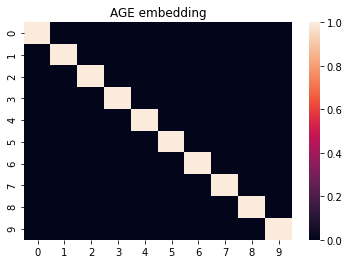

In [25]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

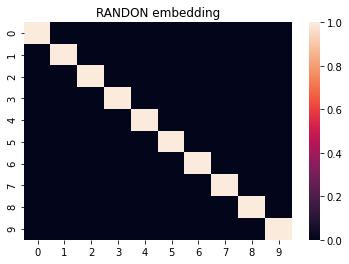

In [26]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

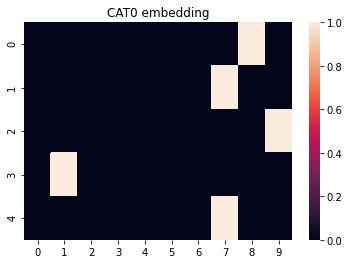

In [27]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

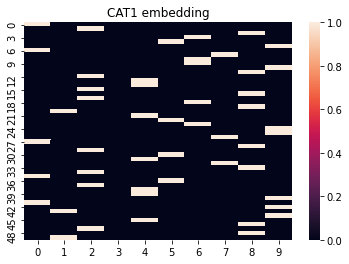

In [28]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [29]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

epoch1
====> Train NLL: 2.302 	 Valid NLL: 1.127 CI: 0.786 event loss: 77.592 	 censoring loss : 20.856 	 Improved: *
epoch2
====> Train NLL: 2.154 	 Valid NLL: 1.040 CI: 0.799 event loss: 71.887 	 censoring loss : 20.029 	 Improved: *
epoch3
====> Train NLL: 2.010 	 Valid NLL: 0.968 CI: 0.812 event loss: 60.453 	 censoring loss : 17.499 	 Improved: *
epoch4
====> Train NLL: 1.876 	 Valid NLL: 0.893 CI: 0.830 event loss: 45.322 	 censoring loss : 12.460 	 Improved: *
epoch5
====> Train NLL: 1.737 	 Valid NLL: 0.821 CI: 0.849 event loss: 33.999 	 censoring loss : 9.136 	 Improved: *
epoch6
====> Train NLL: 1.627 	 Valid NLL: 0.766 CI: 0.864 event loss: 28.185 	 censoring loss : 7.021 	 Improved: *
epoch7
====> Train NLL: 1.534 	 Valid NLL: 0.725 CI: 0.873 event loss: 25.221 	 censoring loss : 5.454 	 Improved: *
epoch8
====> Train NLL: 1.473 	 Valid NLL: 0.697 CI: 0.879 event loss: 23.892 	 censoring loss : 4.829 	 Improved: *
epoch9
====> Train NLL: 1.433 	 Valid NLL: 0.674 CI: 0.883 e

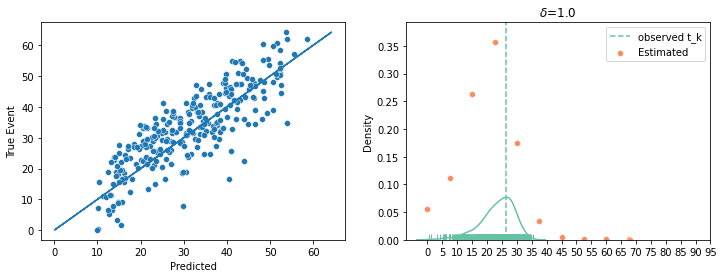

====> Train NLL: 1.399 	 Valid NLL: 0.657 CI: 0.887 event loss: 22.371 	 censoring loss : 3.858 	 Improved: *
epoch11
====> Train NLL: 1.368 	 Valid NLL: 0.642 CI: 0.890 event loss: 21.818 	 censoring loss : 3.389 	 Improved: *
epoch12
====> Train NLL: 1.344 	 Valid NLL: 0.630 CI: 0.892 event loss: 20.700 	 censoring loss : 3.173 	 Improved: *
epoch13
====> Train NLL: 1.325 	 Valid NLL: 0.620 CI: 0.894 event loss: 20.968 	 censoring loss : 2.873 	 Improved: *
epoch14
====> Train NLL: 1.315 	 Valid NLL: 0.611 CI: 0.895 event loss: 20.842 	 censoring loss : 2.955 	 Improved: *
epoch15
====> Train NLL: 1.302 	 Valid NLL: 0.605 CI: 0.896 event loss: 20.956 	 censoring loss : 2.885 	 Improved: *
epoch16
====> Train NLL: 1.290 	 Valid NLL: 0.600 CI: 0.896 event loss: 20.354 	 censoring loss : 2.769 	 Improved: *
epoch17
====> Train NLL: 1.282 	 Valid NLL: 0.596 CI: 0.897 event loss: 19.983 	 censoring loss : 2.519 	 Improved: *
epoch18
====> Train NLL: 1.274 	 Valid NLL: 0.593 CI: 0.897 even

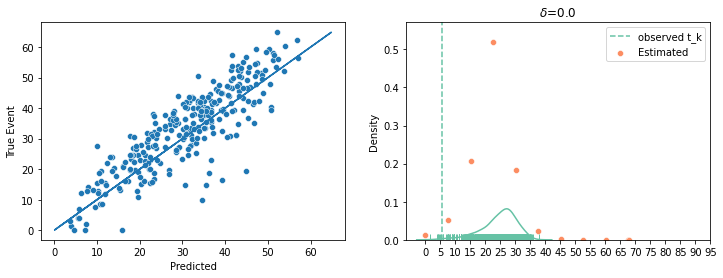

====> Train NLL: 1.266 	 Valid NLL: 0.589 CI: 0.897 event loss: 20.363 	 censoring loss : 2.476 	 Improved: *
epoch21
====> Train NLL: 1.267 	 Valid NLL: 0.587 CI: 0.897 event loss: 20.367 	 censoring loss : 2.472 	 Improved: *
epoch22
====> Train NLL: 1.258 	 Valid NLL: 0.586 CI: 0.898 event loss: 19.844 	 censoring loss : 2.260 	 Improved: *
epoch23
====> Train NLL: 1.262 	 Valid NLL: 0.585 CI: 0.898 event loss: 20.037 	 censoring loss : 2.339 	 Improved: *
epoch24
====> Train NLL: 1.259 	 Valid NLL: 0.584 CI: 0.898 event loss: 20.510 	 censoring loss : 2.408 	 Improved: *
epoch25
====> Train NLL: 1.250 	 Valid NLL: 0.582 CI: 0.898 event loss: 20.548 	 censoring loss : 2.446 	 Improved: *
epoch26
====> Train NLL: 1.247 	 Valid NLL: 0.581 CI: 0.898 event loss: 20.667 	 censoring loss : 2.284 	 Improved:  
epoch27
====> Train NLL: 1.251 	 Valid NLL: 0.581 CI: 0.898 event loss: 20.920 	 censoring loss : 2.428 	 Improved:  
epoch28
====> Train NLL: 1.250 	 Valid NLL: 0.580 CI: 0.898 even

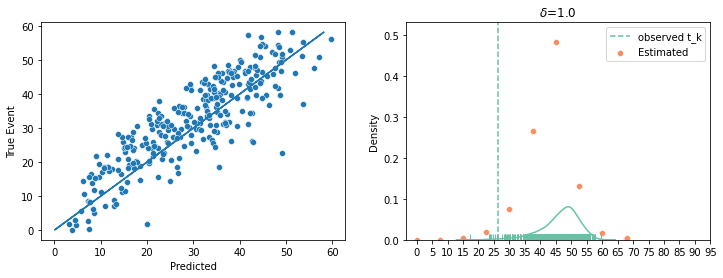

====> Train NLL: 1.247 	 Valid NLL: 0.579 CI: 0.898 event loss: 21.254 	 censoring loss : 2.440 	 Improved:  
epoch31
====> Train NLL: 1.243 	 Valid NLL: 0.578 CI: 0.898 event loss: 20.412 	 censoring loss : 2.269 	 Improved: *
epoch32
====> Train NLL: 1.236 	 Valid NLL: 0.577 CI: 0.898 event loss: 20.491 	 censoring loss : 2.396 	 Improved:  
epoch33
====> Train NLL: 1.244 	 Valid NLL: 0.577 CI: 0.898 event loss: 19.990 	 censoring loss : 2.256 	 Improved: *
epoch34
====> Train NLL: 1.240 	 Valid NLL: 0.577 CI: 0.898 event loss: 20.067 	 censoring loss : 2.323 	 Improved: *
epoch35
====> Train NLL: 1.240 	 Valid NLL: 0.576 CI: 0.898 event loss: 20.039 	 censoring loss : 2.172 	 Improved: *
epoch36
====> Train NLL: 1.229 	 Valid NLL: 0.576 CI: 0.898 event loss: 20.169 	 censoring loss : 2.195 	 Improved:  
epoch37
====> Train NLL: 1.239 	 Valid NLL: 0.576 CI: 0.898 event loss: 20.190 	 censoring loss : 2.128 	 Improved:  
epoch38
====> Train NLL: 1.233 	 Valid NLL: 0.574 CI: 0.898 even

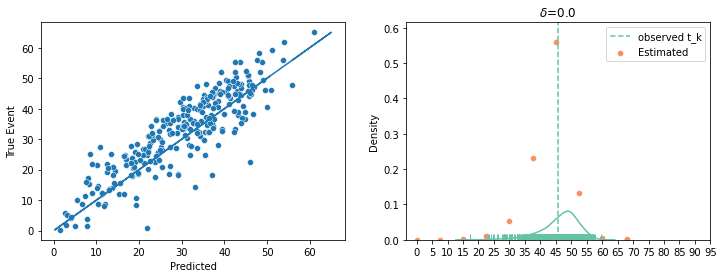

====> Train NLL: 1.234 	 Valid NLL: 0.574 CI: 0.898 event loss: 20.284 	 censoring loss : 2.235 	 Improved:  
epoch41
====> Train NLL: 1.230 	 Valid NLL: 0.573 CI: 0.898 event loss: 20.581 	 censoring loss : 2.320 	 Improved: *
epoch42
====> Train NLL: 1.229 	 Valid NLL: 0.574 CI: 0.898 event loss: 20.794 	 censoring loss : 2.384 	 Improved:  
epoch43
====> Train NLL: 1.224 	 Valid NLL: 0.573 CI: 0.898 event loss: 21.518 	 censoring loss : 2.462 	 Improved:  
epoch44
====> Train NLL: 1.227 	 Valid NLL: 0.573 CI: 0.898 event loss: 21.419 	 censoring loss : 2.575 	 Improved:  
epoch45
====> Train NLL: 1.228 	 Valid NLL: 0.573 CI: 0.898 event loss: 21.386 	 censoring loss : 2.351 	 Improved:  
epoch46
====> Train NLL: 1.228 	 Valid NLL: 0.573 CI: 0.898 event loss: 21.029 	 censoring loss : 2.444 	 Improved: *
epoch47
====> Train NLL: 1.224 	 Valid NLL: 0.571 CI: 0.898 event loss: 20.720 	 censoring loss : 2.349 	 Improved: *
epoch48
====> Train NLL: 1.224 	 Valid NLL: 0.571 CI: 0.898 even

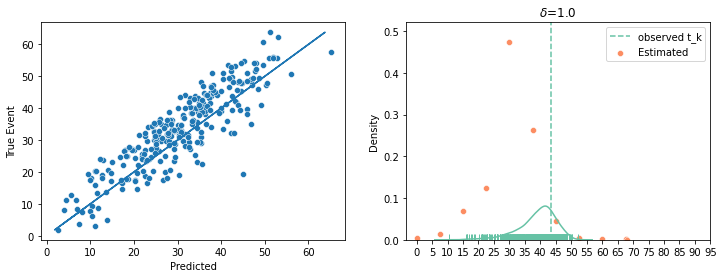

====> Train NLL: 1.228 	 Valid NLL: 0.572 CI: 0.898 event loss: 20.324 	 censoring loss : 2.270 	 Improved:  
epoch51
====> Train NLL: 1.222 	 Valid NLL: 0.572 CI: 0.898 event loss: 20.847 	 censoring loss : 2.414 	 Improved:  
epoch52
====> Train NLL: 1.217 	 Valid NLL: 0.571 CI: 0.898 event loss: 20.153 	 censoring loss : 2.169 	 Improved: *
epoch53
====> Train NLL: 1.222 	 Valid NLL: 0.570 CI: 0.898 event loss: 20.473 	 censoring loss : 2.304 	 Improved: *
epoch54


KeyboardInterrupt: 

In [30]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
#     attention.train()
    decoder.train()


    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2]).to(device).float()
        e = torch.cat([e1,e2]).to(device)
                
        if not ctr_learning:
            ctr_wt = 0
            
        x_emb = embedding(x.float())
#         z = attention(x_emb)
        z, attn_score = attention(x_emb,x_emb,x_emb)

        p_raw = decoder(z)
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + lambda_*loss_est
    
        # contrastive learning step
        delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        keep_idx_1 = torch.where(delete_loc==0)[0]
        keep_idx_2 = keep_idx_1+len(e1)

        batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

        batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())

        # update parameters
        loss = surv_loss + ctr_wt*contrastive_loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += contrastive_loss.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
#         z = attention(x_emb)
        z, attn_score = attention(x_emb,x_emb,x_emb)

        p_raw = decoder(z)
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + lambda_*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze())
        valid_t.append(y.squeeze())
        valid_e.append(e.squeeze())   
        
    # concatenate all the validation results
    valid_e = torch.cat(valid_e)
    valid_t = torch.cat(valid_t)
    valid_pred_t = torch.cat(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t)[0]
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1
        

        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)

        sns.scatterplot(t_wa_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu())
        plt.plot(y[e==1].cpu(), y[e==1].cpu())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        subj = np.random.choice(len(e))
        plt.subplot(1, 2, 2)

        plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw[subj,:].cpu().detach().numpy(), label='Estimated', color=pred_color)
        sample_x = x[subj,:].cpu().numpy()

        true_T = single_subj_true_dist_cox_gompertz(sample_x, true_beta)['T']
        sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(e[subj].item()))
        plt.show()

    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
#         torch.save(attention.state_dict(), att_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

In [ ]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.legend()


In [ ]:
plt.plot(train_lost_ctr_hist,label="contrastive losses")
plt.legend()

In [ ]:
embedding.load_state_dict(torch.load(emb_path))
# attention.load_state_dict(torch.load(att_path))

decoder.load_state_dict(torch.load(dec_path))

# for name, param in embedding.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [ ]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

In [ ]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [ ]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

embedding.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    x_emb = embedding(x.float())
    z, attn_score = attention(x_emb,x_emb,x_emb)

    p_raw = decoder(z)

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + lambda_*loss_est
    
    valid_pred_t.append(t_wa_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())
    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()

print(valid_e_loss)


In [ ]:
attn_score_avg = attn_score.mean(axis=0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')